In [1]:
import torch 

results_dir = "/data/users/igeorvasilis/ddpm_cl/cifar10/lin_sched_t950" 

pretrained_model_dirs = [
    { "dir": f"{results_dir}/0", "title": "T1", "images": None, "labels":[0], "pipe":"ddim"},
    { "dir": f"{results_dir}/m0", "title": "MT1", "images": None, "labels":[0], "pipe":"ts_ddim"},
    { "dir": f"{results_dir}/1", "title": "T2", "images": None, "labels":[1], "pipe":"ddim"},
    { "dir": f"{results_dir}/m1", "title": "MT2", "images": None, "labels":[1], "pipe":"ddim"},
    { "dir": f"{results_dir}/0n1", "title": "T1 & T2", "images": None, "labels":[0, 1], "pipe":"ddim"},
    { "dir": f"{results_dir}/0n1_from_0", "title": "T1 & T2 from T1", "images": None, "labels":[0, 1], "pipe":"ddim"},
    { "dir": f"{results_dir}/m0n1_from_m0", "title": "T1 & T2 from MT1", "images": None, "labels":[0, 1], "pipe":"ddim"},
    { "dir": f"{results_dir}/0n1_from_1", "title": "T1 & T2 from T2", "images": None, "labels":[0, 1], "pipe":"ddim"},
    { "dir": f"{results_dir}/m0n1_from_m1", "title": "T1 & T2 from MT2", "images": None, "labels":[0, 1], "pipe":"ddim"},
]

In [2]:
def get_img_given_title(title):
    for key in pretrained_model_dirs:
        if key["title"] == title:
            return key["images"]
    return None

In [42]:
torch.manual_seed(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 5000, Number of test images: 1000


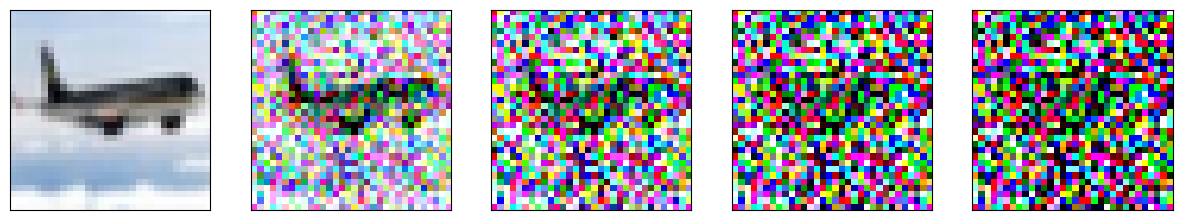

In [54]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils import make_image_grid
from pipelines import TS_DDIMPipeline
from diffusers import DDIMPipeline
import torch 
import torchvision
from dataset import init_dataset
import matplotlib.pyplot as plt

# Create eval dataloader
trainset, testset = init_dataset(dataset_name="CIFAR10", dataset_path="/data/datasets/cifar10", 
                                 labels=[0], preprocess=torchvision.transforms.Compose([ torchvision.transforms.ToTensor()]))

# trainset = torch.utils.data.ConcatDataset([trainset, testset])
eval_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=1, shuffle=True)

lin_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear")

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

x0 = next(iter(eval_dataloader))[0]
ts = [900, 800, 600, 500, 400, 300, 200, 100]
noise = torch.randn(size=x0.shape)
axes[0].imshow(x0[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[7], ts[7], ts[7], ts[7]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[1].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[6], ts[6], ts[6], ts[6]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[2].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[5], ts[5], ts[5], ts[5]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[3].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[4], ts[4], ts[4], ts[4]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[4].imshow(x1[0].permute(1, 2, 0).numpy())

# remove ticks 
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 5000, Number of test images: 1000


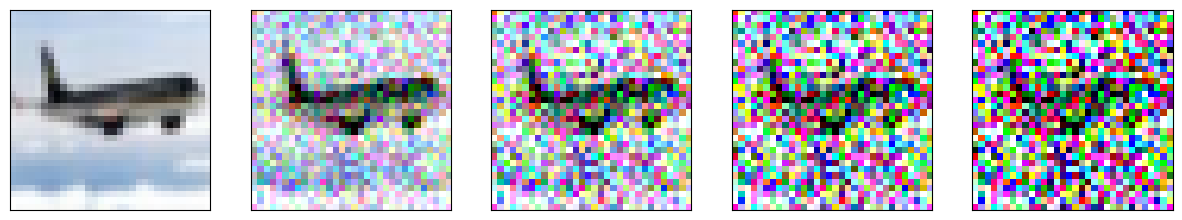

In [55]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils import make_image_grid
from pipelines import TS_DDIMPipeline
from diffusers import DDIMPipeline
import torch 
import torchvision
from dataset import init_dataset
import matplotlib.pyplot as plt

# Create eval dataloader
trainset, testset = init_dataset(dataset_name="CIFAR10", dataset_path="/data/datasets/cifar10", 
                                 labels=[0], preprocess=torchvision.transforms.Compose([ torchvision.transforms.ToTensor()]))

# trainset = torch.utils.data.ConcatDataset([trainset, testset])
eval_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=1, shuffle=True)

lin_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="squaredcos_cap_v2")

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

axes[0].imshow(x0[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[7], ts[7], ts[7], ts[7]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[1].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[6], ts[6], ts[6], ts[6]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[2].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[5], ts[5], ts[5], ts[5]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[3].imshow(x1[0].permute(1, 2, 0).numpy())

# repeat timestep[0] 4 times
t = torch.Tensor([ts[4], ts[4], ts[4], ts[4]]).long()
x1 = lin_scheduler.add_noise(x0, timesteps=t, noise=noise)
axes[4].imshow(x1[0].permute(1, 2, 0).numpy())

# remove ticks 
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [45]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils import make_image_grid
from pipelines import TS_DDIMPipeline
from diffusers import DDIMPipeline

for experiment in pretrained_model_dirs:
    
    model = UNet2DModel.from_pretrained(f'{experiment["dir"]}/epoch-200', subfolder="unet", use_safetensors=True).to('cuda:0')
    noise_scheduler = DDPMScheduler.from_pretrained(f'{experiment["dir"]}/epoch-200', subfolder="scheduler", use_safetensors=True)
    
    # load args.pt 
    experiment_args = torch.load(f"{experiment['dir']}/args.pt")

    if experiment["pipe"] == "ts_ddim":
        pipeline = TS_DDIMPipeline(unet=model, scheduler=noise_scheduler, labels = experiment["labels"])
    elif experiment["pipe"] == "ddim":
        pipeline = DDIMPipeline(unet=model, scheduler=noise_scheduler)

    with torch.no_grad(): images = pipeline(
            batch_size=32, num_inference_steps=50, 
            generator=torch.manual_seed(0)
    ).images

    # Save the images
    image_grid = make_image_grid(images, rows=4, cols=8)
    experiment["images"] = image_grid

NameError: name 'pretrained_model_dirs' is not defined

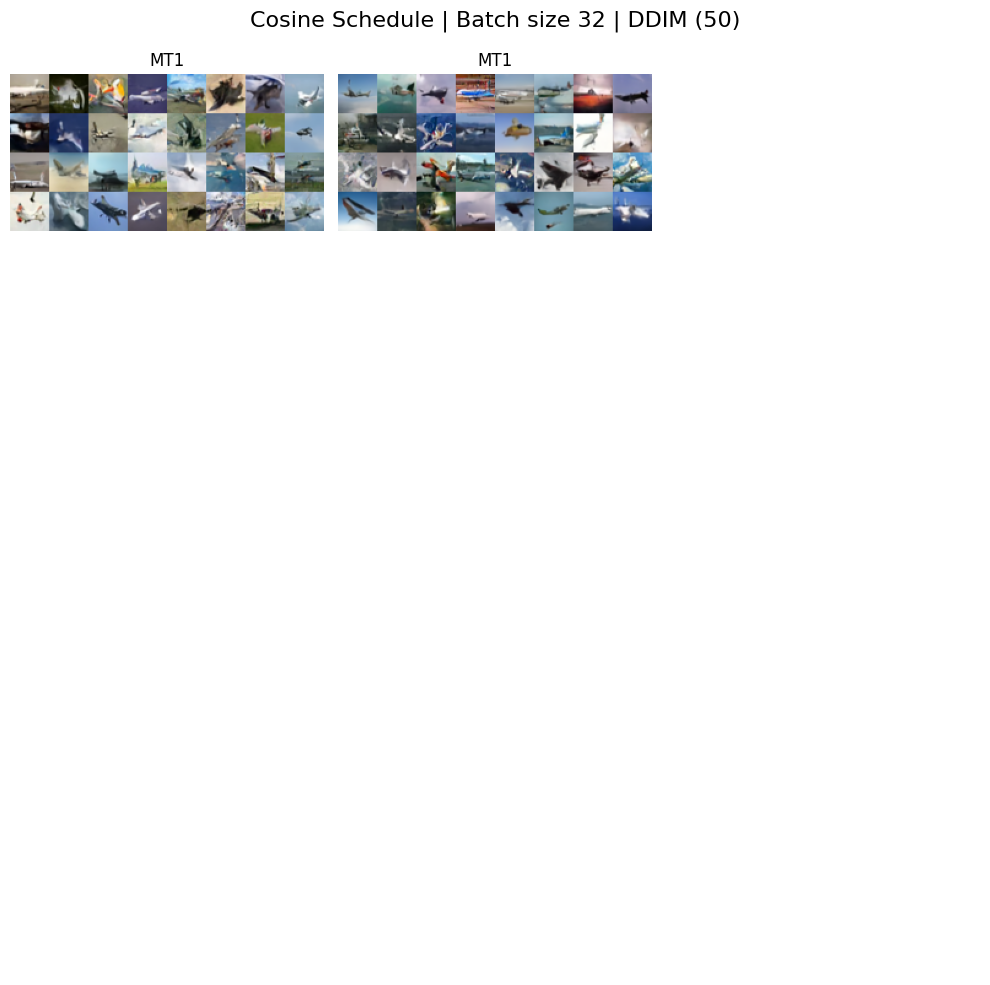

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(10, 10))

axes[0, 0].imshow(get_img_given_title('T1')); axes[0, 0].set_title("T1")
axes[0, 1].imshow(get_img_given_title('MT1')); axes[0, 1].set_title("MT1")

axes[1, 0].imshow(get_img_given_title('T2')); axes[1, 0].set_title("T2")
axes[1, 1].imshow(get_img_given_title('MT2')); axes[1, 1].set_title("MT2")

axes[2, 0].imshow(get_img_given_title('T1 & T2')); axes[2, 0].set_title("T1 & T2")
axes[2, 1].imshow(get_img_given_title('T1 & T2 from T1')); axes[2, 1].set_title("T1 & T2 from T1")
axes[2, 2].imshow(get_img_given_title('T1 & T2 from MT1')); axes[2, 2].set_title("T1 & T2 from MT1")

axes[3, 0].imshow(get_img_given_title('T1 & T2')); axes[3, 0].set_title("T1 & T2")
axes[3, 1].imshow(get_img_given_title('T1 & T2 from T2')); axes[3, 1].set_title("T1 & T2 from T2")
axes[3, 2].imshow(get_img_given_title('T1 & T2 from MT2')); axes[3, 2].set_title("T1 & T2 from MT2")

# Add title to figure
fig.suptitle("Cosine Schedule | Batch size 32 | DDIM (50)", fontsize=16)

# Remove all the ticks (both axes), and tick labels on the Y axis
for ax in axes.flatten(): ax.axis('off')

plt.tight_layout()